In [79]:
########################################
# Author: Christopher O'Toole
# Assignment: Homework #4
# Date: 10/3/2018
# Class: CS5402
########################################

# iris dataset is actually built into
# sklearn, so no need to download any
# csv files. length is 150 which is
# equivalent to the the set linked
# in the assignment
from sklearn.datasets import load_iris
iris = load_iris()

In [80]:
########################################
# Implementation of cross-validation 
# function + decision tree model training
# and visualization.
########################################
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np

# the definitive meaning of life.
SEED = 42

def my_cross_val_score(clf, X, y, **kwargs):
    # basic implementation of the sklearn equivalent "cross_val_score"
    # note that that this implementation differs in the sense that no
    # attempt to perform stratified sampling is made
    np.random.seed(SEED)
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    folds = kwargs.get('cv') if 'cv' in kwargs else 5
    scoring = kwargs.get('scoring') if 'scoring' in kwargs else 'accuracy'
    metrics = {'accuracy': accuracy_score, 'f1_macro': f1_score}
    n = len(X)
    # create an id for each record
    idxs = np.arange(n)
    # represents a random shuffle of our dataset records
    np.random.shuffle(idxs)
    # partition the dataset into relatively equal sized subsets
    partitions = [(int(np.ceil(n*(i-1)/folds)), int(np.ceil(n*i/folds))) for i in range(1, folds+1)]
    results = []
    
    for start, end in partitions:
        # take advantage of numpy style indexing here by using boolean arrays to indicate which
        # elements are in the partition subset
        mask = np.zeros(n, np.bool)
        mask[start:end] = 1
        train_mask = np.invert(mask)
        X_train, y_train, X_test, y_test = X[idxs[train_mask]], y[idxs[train_mask]], X[idxs[mask]], y[idxs[mask]]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        # compute macro (unweighted average across classes [one v. all]) f1 score
        kwargs = {k: v for k, v in [('average', 'macro')] if 'f1' in scoring}
        results.append(metrics[scoring](y_test, y_pred, **kwargs))
    
    return results
    
# number of cross-validation folds
CROSS_VAL_FOLDS = 5
decision_tree = DecisionTreeClassifier(random_state=SEED)
accuracies = my_cross_val_score(decision_tree, iris.data, iris.target, cv=CROSS_VAL_FOLDS, scoring='accuracy')
decision_tree_eval = (np.mean(accuracies), decision_tree)
decision_tree_eval_f1 = (np.mean(my_cross_val_score(decision_tree, iris.data, iris.target, cv=CROSS_VAL_FOLDS, scoring='f1_macro')), decision_tree)
# randomly splits the dataset into test and training sets
# this wouldn't be that hard to derive from my above splitting algorithm
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=1./CROSS_VAL_FOLDS, random_state=SEED)
decision_tree.fit(X_train, y_train)
tree.export_graphviz(decision_tree, out_file='tree.dot')
y_tree_pred = decision_tree.predict(X_test)
y_tree_pred_train = decision_tree.predict(X_train)

tree_results = {
    'train_acc': decision_tree.score(X_train, y_train), 
    'train_f1': f1_score(y_train, y_tree_pred_train, average='macro'),
    'test_acc': decision_tree.score(X_test, y_test),
    'test_f1': f1_score(y_test, y_tree_pred, average='macro')
}

print('Training set accuracy: {0:.2f}%'.format(tree_results['train_acc']*100))
print('Training set f1-score: {0:.2f}'.format(tree_results['train_f1']))
print('Test set accuracy: {0:.2f}%'.format(tree_results['test_acc']*100))
print('Test set f1-score: {0:.2f}'.format(tree_results['test_f1']))
print('Best accuracies:', accuracies)

Training set accuracy: 100.00%
Training set f1-score: 1.00
Test set accuracy: 100.00%
Test set f1-score: 1.00
Best accuracies: [1.0, 0.9666666666666667, 0.9333333333333333, 0.9333333333333333, 0.9333333333333333]


In [81]:
########################################
# Tunes the k parameter for our k-nearest
# neighbors classifier.
########################################
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
best = -np.inf
evals = {}
sequential_evals = [[], [], []]
best_accuracies = None
MAX_K = 25

for k in range(1, MAX_K):
    knn_classifier = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    accuracies = my_cross_val_score(knn_classifier, iris.data, iris.target, cv=CROSS_VAL_FOLDS, scoring='accuracy')
    mean_score = np.mean(accuracies)
    f1s = my_cross_val_score(knn_classifier, iris.data, iris.target, cv=CROSS_VAL_FOLDS, scoring='f1_macro')
    mean_f1_score = np.mean(f1s)
    
    sequential_evals[0].append(k)
    sequential_evals[1].append(mean_score)
    sequential_evals[2].append(mean_f1_score)
    
    if mean_score > best:
        evals[mean_score] = (k, knn_classifier)
        best = mean_score
        best_accuracies = accuracies

keys = list(evals.keys())
best_model_idx = np.argmax(np.asarray(keys))
eval_df = pd.DataFrame(data={key: values for key, values in zip(('k', 'accuracy', 'f1-macro-score'), sequential_evals)})
eval_df.head()

,k,accuracy,f1-macro-score
0,1,0.960000,0.959943
1,2,0.960000,0.959943
2,3,0.966667,0.965934
3,4,0.973333,0.973364
4,5,0.973333,0.974237


Best KNN model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
           weights='uniform')
Best KNN model training set accuracy: 96.67%
Best KNN model training set f1-score: 0.97
Best KNN model test accuracy: 100.00%
Best KNN model test f1-score: 1.00
Best accuracies: [1.0, 1.0, 0.9666666666666667, 0.9666666666666667, 0.9666666666666667]


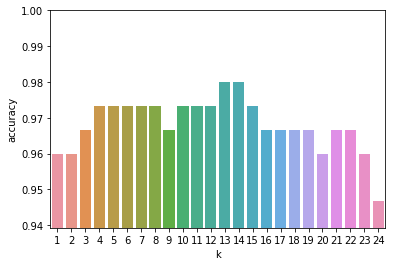

In [82]:
########################################
# Plot k-nearest neighbor accuracies
########################################
# seaborn creates a good contrast color
# scheme for plotting
import seaborn as sns
ax = sns.barplot(x='k', y='accuracy', data=eval_df)
ax.set_ylim(bottom=(eval_df['accuracy'].min() - eval_df['accuracy'].std()), top=1.0)
model = evals[keys[best_model_idx]][1]
print('Best KNN model:', model)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)
knn_results = {
    'train_acc': model.score(X_train, y_train),
    'train_f1': f1_score(y_train, y_pred_train, average='macro'),
    'test_acc': model.score(X_test, y_test),
    'test_f1': f1_score(y_test, y_pred, average='macro')
}
print('Best KNN model training set accuracy: {0:.2f}%'.format(knn_results['train_acc']*100))
print('Best KNN model training set f1-score: {0:.2f}'.format(knn_results['train_f1']))
print('Best KNN model test accuracy: {0:.2f}%'.format(knn_results['test_acc']*100))
print('Best KNN model test f1-score: {0:.2f}'.format(knn_results['test_f1']))
print('Best accuracies:', best_accuracies)

(0.9397285013647093, 1.0)

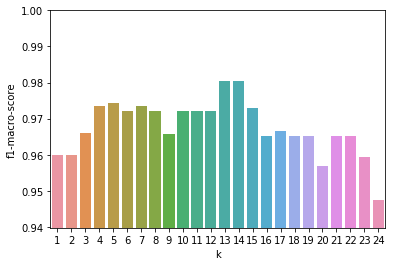

In [83]:
########################################
# Plots the k-nearest neighbor f1 scores
########################################
ax = sns.barplot(x='k', y='f1-macro-score', data=eval_df)
ax.set_ylim(bottom=(eval_df['f1-macro-score'].min() - eval_df['f1-macro-score'].std()), top=1.0)

(0.9, 1.0)

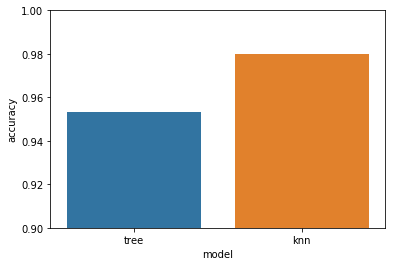

In [84]:
########################################
# Test set evaluation of our classifiers
# over the accuracy metric
########################################

results = {
    'model': ['tree', 'knn'], 
    'accuracy': [decision_tree_eval[0], keys[best_model_idx]]
}

decision_tree_vs_knn_df = pd.DataFrame(data=results)
decision_tree_vs_knn_df.columns
ax = sns.barplot(x='model', y='accuracy', data=decision_tree_vs_knn_df)
ax.set_ylim(bottom=.9, top=1.0)

Index(['model', 'f1-score'], dtype='object')


(0.9, 1.0)

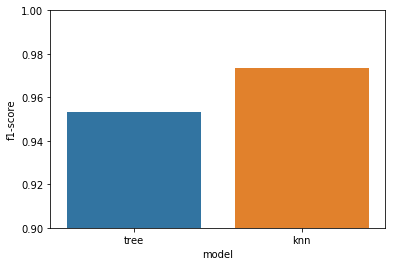

In [85]:
########################################
# Test set evaluation of our classifiers
# over the f1 metric
########################################

f1_results = {
    'model': ['tree', 'knn'], 
    'f1-score': [decision_tree_eval_f1[0], eval_df['f1-macro-score'][best_model_idx]]
}

decision_tree_vs_knn_df = pd.DataFrame(data=f1_results)
print(decision_tree_vs_knn_df.columns)
ax = sns.barplot(x='model', y='f1-score', data=decision_tree_vs_knn_df)
ax.set_ylim(bottom=.9, top=1.0)

In [86]:
########################################
# Save each trained model to a file
########################################

from sklearn.externals import joblib
joblib.dump(decision_tree, 'tree.joblib')
joblib.dump(model, 'knn.joblib')


['knn.joblib']

In [87]:
########################################
# Proof of concept to show that loading
# the model and then making a prediction
# is successful
########################################
tree = joblib.load('tree.joblib')
print(tree, tree.predict(X_train))
knn = joblib.load('knn.joblib')
print(knn, knn.predict(X_train))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best') [0 0 1 0 0 2 1 0 0 0 2 1 1 0 0 1 2 2 1 2 1 2 1 0 2 1 0 0 0 1 2 0 0 0 1 0 1
 2 0 1 2 0 2 2 1 1 2 1 0 1 2 0 0 1 1 0 2 0 0 1 1 2 1 2 2 1 0 0 2 2 0 0 0 1
 2 0 2 2 0 1 1 2 1 2 0 2 1 2 1 1 1 0 1 1 0 1 2 2 0 1 2 2 0 2 0 1 2 2 1 2 1
 1 2 2 0 1 2 0 1 2]
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
           weights='uniform') [0 0 1 0 0 2 1 0 0 0 2 1 1 0 0 1 2 2 1 2 1 2 1 0 2 1 0 0 0 1 2 0 0 0 1 0 1
 2 0 1 2 0 2 2 1 1 2 1 0 1 2 0 0 1 2 0 2 0 0 2 1 2 2 2 2 1 0 0 2 2 0 0 0 1
 2 0 2 2 0 1 1 2 1 2 0 2 1 2 1 1 1 0 1 1 0 1 2 2 0 1 2 2 0 2 0 1 2 2 1 2 1
 1 2 2 0 1 1 0 1